# Анализ NWOE и NIV для оценки ATE на данных Criteo Uplift Prediction
Данный скрипт предназначен для анализа и визуализации данных из датасета Criteo Uplift Prediction
## Задачи:
- Предобработка данных и EDA
- Расчёт NWOE/NIV с помощью pylift
- Визуализация результатов 
- Формулировка рекомендаций по результатам анализа


Автор: Ерошкин Юрий, июнь 2025.

In [3]:
# Импорт библиотек для анализа и визуализации
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')
sns.set_style('whitegrid')  # Сетчатый стиль для всех графиков
sns.set_palette("Set2")     # Фиксируем палитру для всех графиков

from tqdm import tqdm
from pylift import TransformedOutcome
from sklearn.preprocessing import MinMaxScaler
from optbinning import BinningProcess

# Для корректного отображения графиков в jupyter
%matplotlib inline

In [2]:
# Чтение датасета
df = pd.read_csv('criteo-uplift-v2.1.csv')

Просматриваем размер, типы столбцов и наличие пропусков для быстрой проверки структуры исходного датасета перед дальнейшей обработкой.

In [3]:
# Краткая инфа по колонкам, типам, пропускам
print(f"Shape: {df.shape}")
print("Data Types:\n", df.dtypes)

display(df.head())

# Только столбцы с пропусками, по убыванию:
na = df.isnull().sum()
na = na[na > 0]
if len(na) == 0:
    print("Нет пропусков")
else:
    display(na.sort_values(ascending=False))

Shape: (13979592, 16)
Data Types:
 f0            float64
f1            float64
f2            float64
f3            float64
f4            float64
f5            float64
f6            float64
f7            float64
f8            float64
f9            float64
f10           float64
f11           float64
treatment       int64
conversion      int64
visit           int64
exposure        int64
dtype: object


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


Нет пропусков


Поскольку значения признаков имеют разный масштаб, приведём их к единому диапазону $[0;1]$ с помощью MinMaxScaler.

In [4]:
scaler = MinMaxScaler()
features = [f"f{i}" for i in range(12)]
df[features] = scaler.fit_transform(df[features]) # Масштабируем указанные признаки в интервал [0, 1]
df[features].describe() # Смотрим основные статистики по нормализованным данным

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11
count,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07
mean,4.957171e-01,1.642451e-03,2.772269e-01,9.616953e-01,5.377863e-03,9.933771e-01,8.597350e-01,3.739924e-02,8.863341e-01,4.569011e-02,2.813762e-02,9.981173e-01
std,3.806006e-01,1.666882e-02,3.573586e-01,1.022035e-01,3.166178e-02,3.283965e-02,1.443034e-01,1.682229e-01,1.682535e-01,1.130179e-01,1.433513e-01,1.878836e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,7.795450e-01,0.000000e+00,8.186613e-01,0.000000e+00,0.000000e+00,1.000000e+00
50%,6.587247e-01,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,9.147164e-01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,8.365904e-01,0.000000e+00,6.076472e-01,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [5]:
# Разделяем признаки и целевые переменные
# Фичи
df_features = df.drop(['treatment', 'conversion', 'visit', 'exposure'], axis=1)
# Таргеты
df_targets = df[['conversion', 'visit']]
# Служебные столбцы: принадлежность к группе
df_group = df[['treatment','exposure']]

## Исследовательский анализ признаков (EDA)

На этом этапе изучим распределения всех признаков и их взаимные корреляции. Такие визуализации помогают выявить:
- выбросы и аномалии,
- признаки с дальним от нормального распределением,
- сильно скоррелированные пары признаков, что важно для построения моделей.

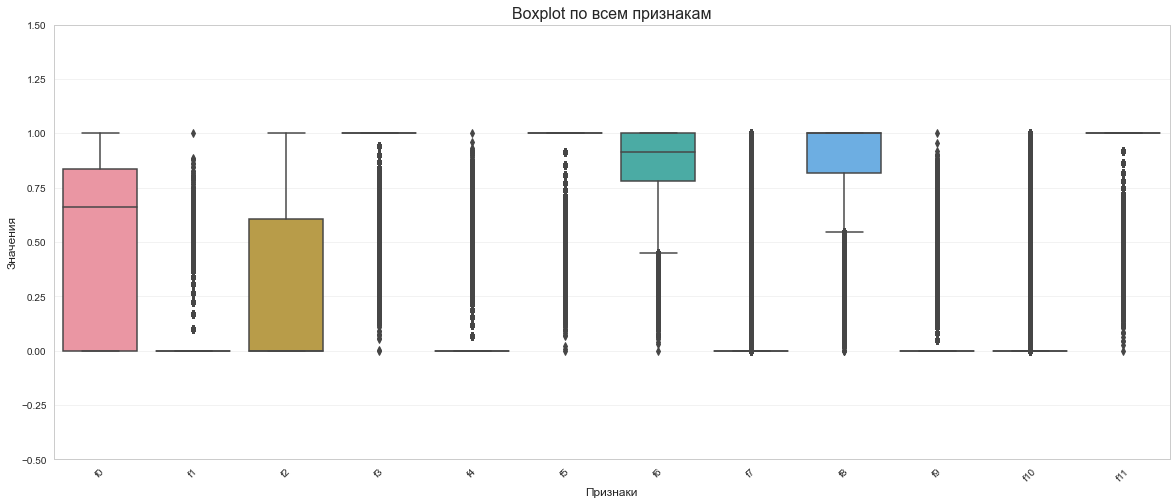

In [6]:
plt.figure(figsize=(20, 8))  # Размер графика
sns.boxplot(data=df_features)  # Boxplot по признакам
plt.ylim(-0.5, 1.5)  # Диапазон Y
plt.title('Boxplot по всем признакам', fontsize=16)
plt.xlabel('Признаки', fontsize=12)
plt.ylabel('Значения', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.3)
plt.show()

#### Вывод по boxplot

- После применения MinMaxScaler все признаки лежат в диапазоне $[0; 1]$.
- Распределения по многим признакам далеки от нормальных: в нормальном распределении основная масса данных сосредоточена вокруг центра, а "усы" симметричны и коротки, выбросов немного. Здесь же для многих признаков наблюдается скошенность, смещённая медиана, а часто значительная часть значений сконцентрирована около 0 или 1.

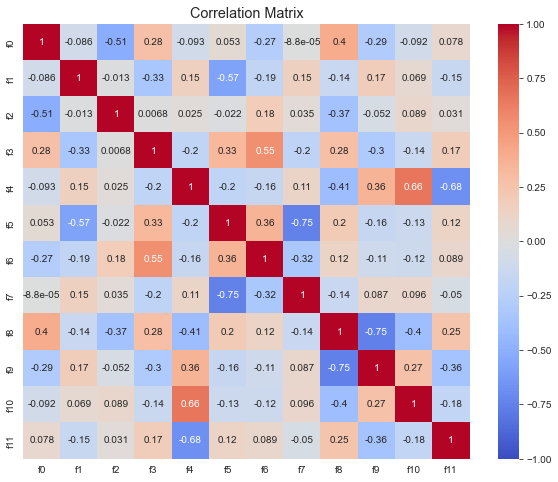

In [7]:
corr_matrix = df_features.corr() # Корреляционная матрица

plt.figure(figsize=(10, 8))  # Размер графика
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)  # Тепловая карта
plt.title('Correlation Matrix')
plt.show()

#### Вывод по корреляционной матрице

- Большинство признаков имеют слабую или умеренную корреляцию.
- Найдено несколько пар признаков с сильной корреляцией:
    - f4 и f10: corr = 0.66
    - f4 и f11: corr = -0.68
    - f5 и f7: corr = -0.75
    - f8 и f9: corr = -0.75

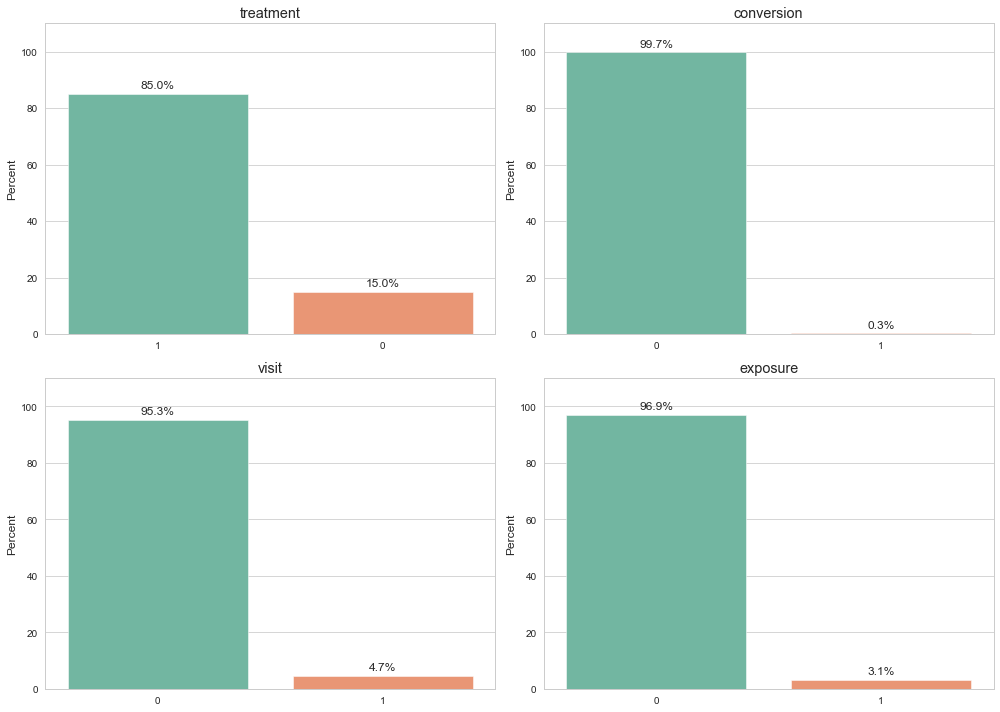

In [8]:
# Создаём сетку 2x2 для четырех графиков
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, col in enumerate(['treatment','conversion', 'visit', 'exposure']):
    # Считаем проценты каждого значения в текущем признаке
    val_counts = df[col].value_counts(normalize=True) * 100  # проценты
    ax = axes[idx]
    
    # Строим столбчатую диаграмму для текущего признака
    sns.barplot(
        x=val_counts.index.astype(str),
        y=val_counts.values,
        ax=ax
    )
    ax.set_title(col)      # Название графика
    ax.set_ylabel('Percent')
    ax.set_ylim(0, 110)    # Единая шкала по Y

    # Подписываем проценты поверх столбцов
    for i, v in enumerate(val_counts.values):
        ax.text(i, v + 2, f"{v:.1f}%", ha='center', fontsize=12)

plt.tight_layout()  # Компактное размещение графиков
plt.show()          # Отображаем результат

#### Комментарии к распределениям:

- Все четыре переменные значительно несбалансированы:
    - `treatment`: 1 — 85%, 0 — 15%.
    - `conversion`: 1 — только 0.3%, 0 — 99.7%.
    - `visit`: 1 — 4.7%, 0 — 95.3%.
    - `exposure`: 1 — 3.1%, 0 — 96.9%.

Plotting: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [09:13<00:00, 46.10s/it]


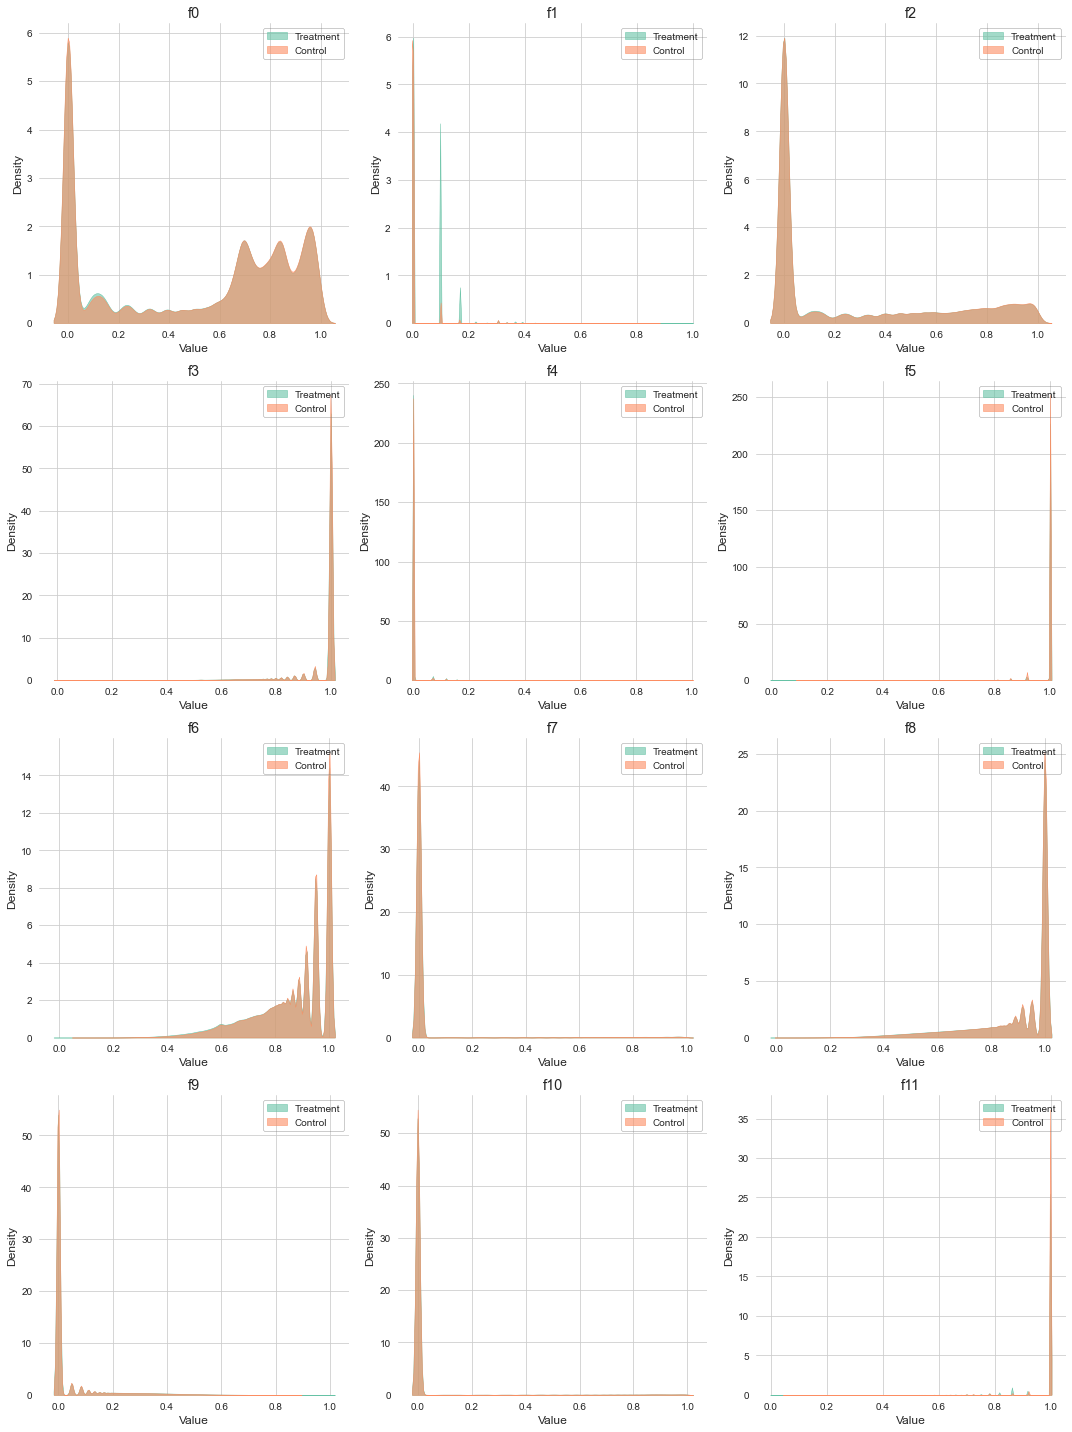

In [9]:
# Получаем названия фичей
features = df_features.columns.tolist()

# Создаём сетку 3x4 для 12 графиков
n_rows, n_cols = 4, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))

# Итерируемся по фичам с tqdm, чтобы был прогресс-бар
for i, feature in tqdm(list(enumerate(features)), desc="Plotting", total=len(features)):
    row, col = divmod(i, n_cols)  # вычисляем позицию на сетке
    ax = axes[row, col]
    
    # График KDE для treatment (treatment=1)
    sns.kdeplot(
        df[df['treatment'] == 1][feature], 
        label='Treatment', fill=True, alpha=0.6, ax=ax, bw_method=0.05
    )
    
    # График KDE для control (treatment=0)  
    sns.kdeplot(
        df[df['treatment'] == 0][feature], 
        label='Control', fill=True, alpha=0.6, ax=ax, bw_method=0.05
    )

    # Оформление графика
    ax.set_title(feature)
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend(facecolor='none')
    if ax.get_legend() is not None:
        ax.get_legend().get_frame().set_edgecolor('grey')
    for spine in ['top', 'right', 'left', 'bottom']:
        ax.spines[spine].set_visible(False)

plt.tight_layout()  # Компактное размещение графиков
plt.show()          # Отображаем результат

Распределения большинства признаков (кроме f1) для групп Treatment и Control практически совпадают, что указывает на отсутствие значимых различий между этими группами по выбранным признакам.

Обратим внимание на переменную exposure, учёт которой заметно влияет на распределения признаков.

Plotting: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [07:45<00:00, 38.79s/it]


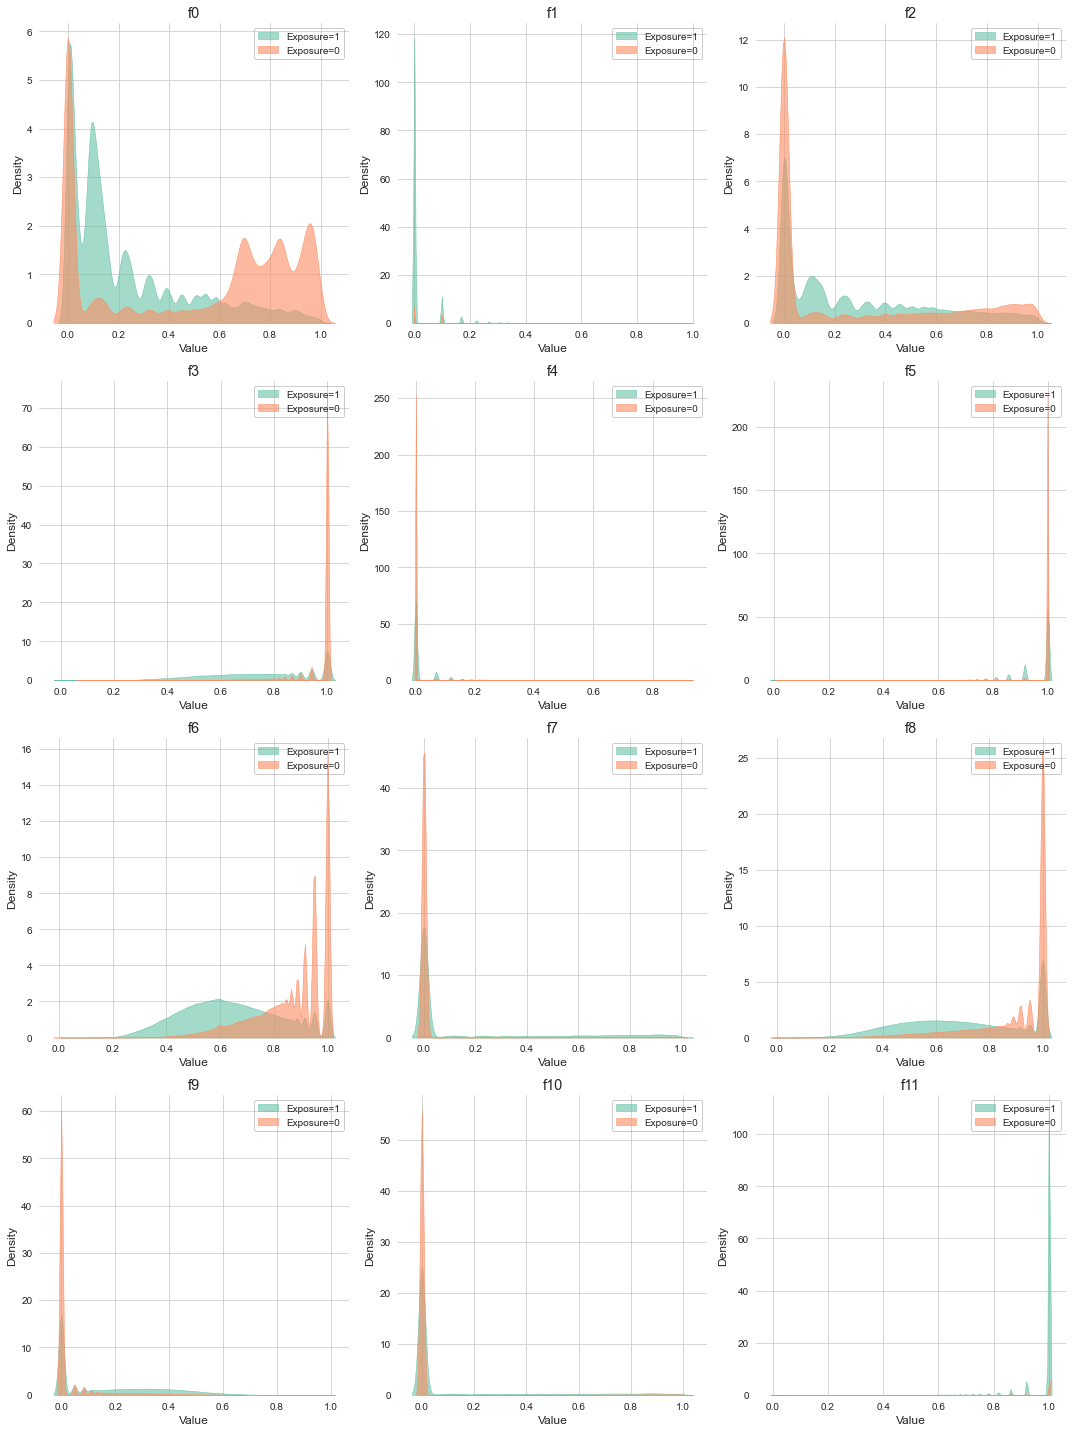

In [10]:
# Получаем названия фичей
features = df_features.columns.tolist()

# Создаём сетку 3x4 для 12 графиков
n_rows, n_cols = 4, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))

# Итерируемся по фичам с tqdm, чтобы был прогресс-бар
for i, feature in tqdm(list(enumerate(features)), desc="Plotting", total=len(features)):
    row, col = divmod(i, n_cols)  # вычисляем позицию на сетке
    ax = axes[row, col]
    
    # График KDE для exposed (treatment=1, exposure=1)
    sns.kdeplot(
        df[(df['exposure'] == 1) & (df['treatment'] == 1)][feature], 
        label='Exposure=1', fill=True, alpha=0.6, ax=ax, bw_method=0.05
    )
    
    # График KDE для unexposed (treatment=1, exposure=0)
    sns.kdeplot(
        df[(df['exposure'] == 0) & (df['treatment'] == 1)][feature], 
        label='Exposure=0', fill=True, alpha=0.6, ax=ax, bw_method=0.05
    )

    # Оформление графика
    ax.set_title(feature)
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend(facecolor='none')
    if ax.get_legend() is not None:
        ax.get_legend().get_frame().set_edgecolor('grey')
    for spine in ['top', 'right', 'left', 'bottom']:
        ax.spines[spine].set_visible(False)

plt.tight_layout()  # Компактное размещение графиков
plt.show()          # Отображаем результат

#### Комментарии к распределениям фичей:
- Распределения ключевых фич существенно различаются между группами exposure=1 и exposure=0, что указывает на зависимость этой переменной (exposure) от характеристик пользователя.

## Расчёт NWOE и NIV 

In [11]:
features = df_features.columns.tolist() # Получаем названия фичей
targets = df_targets.columns.tolist()     # Получаем названия таргетов

woe_tables = {}
iv_tables = {}

def is_interval(bin_label):  #Проверяет, является ли ярлык бина интервальным, например \'[x, y)\'.
    s = str(bin_label)
    return (('[' in s or '(' in s) and (']' in s or ')' in s)) and s not in {'(-inf, inf)'}

for target in targets:
    binning = BinningProcess(variable_names=features)
    binning.fit(df_features, df_targets[target])
    df_binned = binning.transform(df_features, metric='bins')
    records = []
    for f in features:
        binned_var = binning.get_binned_variable(f)
        table = binned_var.binning_table.build()
        counts = df_binned[f].value_counts(dropna=False).sort_index()
        for idx, row in table.iterrows():
            bin_label = row['Bin']
            if not is_interval(bin_label): 
                continue  # Пропускаем неинтервальные бины (например, 'Special')
            count = counts.get(idx, 0)
            records.append({
                'feature': f,
                'bin_num': idx,
                'bin': str(bin_label),
                'count': count,
                'woe': pd.to_numeric(row['WoE'], errors='coerce'),
                'iv': pd.to_numeric(row['IV'], errors='coerce'),
            })
    woe_df = pd.DataFrame(records)

    # Стандартизированное WoE (nwoe)
    woe_df['nwoe'] = woe_df.groupby('feature')['woe'].transform(
        lambda x: x / x.std() if x.std() > 0 else 0
    )
    # Суммарное IV по фиче
    iv_agg = woe_df.groupby('feature')['iv'].sum().reset_index()

    # Для feature, которых нет в records, заполним IV нулями
    iv_agg_full = pd.DataFrame({'feature': features}).merge(iv_agg, on='feature', how='left')
    iv_agg_full['iv'] = iv_agg_full['iv'].fillna(0.0)
    total_iv = iv_agg_full['iv'].sum()
    iv_agg_full['niv'] = iv_agg_full['iv'] / total_iv if total_iv > 0 else 0

    woe_tables[target] = woe_df
    iv_tables[target] = iv_agg_full

# Вывод для каждого таргета nwoe и niv
for target in targets:
    print(f'\n=== WoE for "{target}"')
    print(woe_tables[target][['feature', 'bin', 'count', 'woe', 'nwoe', 'iv']].head(10))
    print(f'\n=== IV for "{target}" ===')
    print(iv_tables[target].sort_values('iv', ascending=False))


=== WoE for "conversion"
  feature           bin    count       woe      nwoe        iv
0      f0  (-inf, 0.00)  3705545  0.477786  0.322532  0.048159
1      f0  [0.00, 0.12)   699603 -1.941542 -1.310648  0.570092
2      f0  [0.12, 0.39)  1182460 -1.110452 -0.749616  0.190082
3      f0  [0.39, 0.61)   935037 -0.527844 -0.356324  0.024497
4      f0  [0.61, 0.68)   698981  0.686148  0.463188  0.017058
5      f0  [0.68, 0.81)  2561829  1.256665  0.848318  0.165094
6      f0  [0.81, 0.93)  2221966  1.606504  1.084478  0.204602
7      f0  [0.93, 0.96)   790417  2.188772  1.477541  0.110173
8      f0   [0.96, inf)  1183754  2.311793  1.560587  0.176825
9      f2  (-inf, 0.00)  7303429  3.495487  1.836470  1.775792

=== IV for "conversion" ===
   feature        iv       niv
8       f8  3.760743  0.242858
2       f2  3.510699  0.226711
9       f9  3.173590  0.204941
0       f0  1.506581  0.097291
3       f3  1.275049  0.082339
6       f6  1.082551  0.069908
7       f7  0.588087  0.037977
5   

Визуализируем полученные данные для удобства

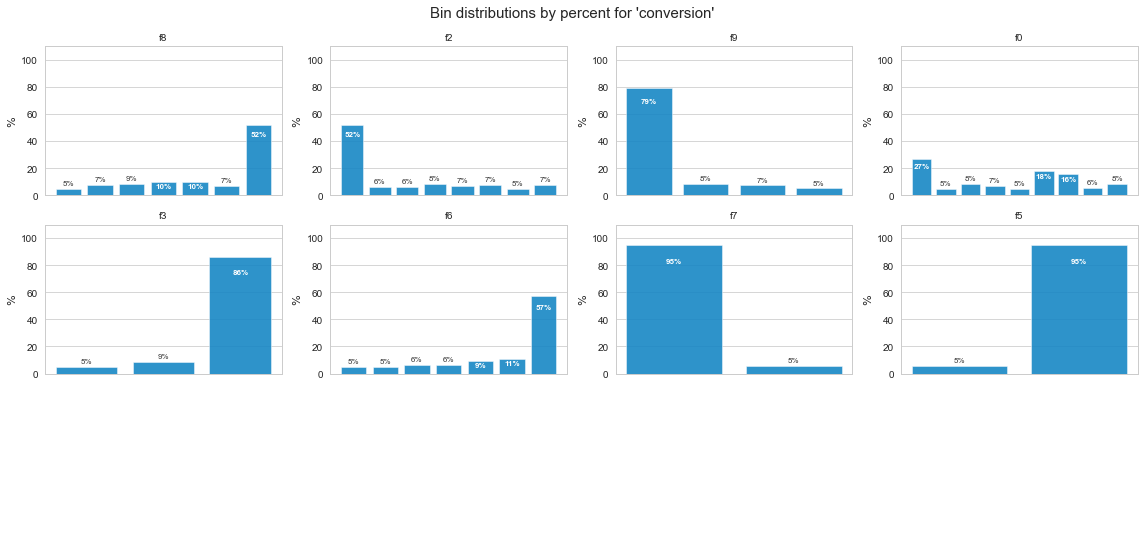

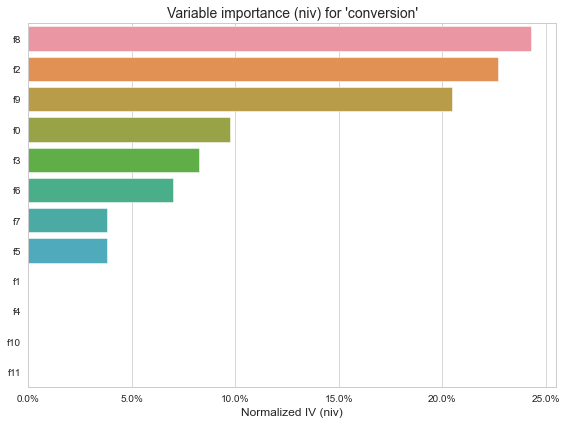

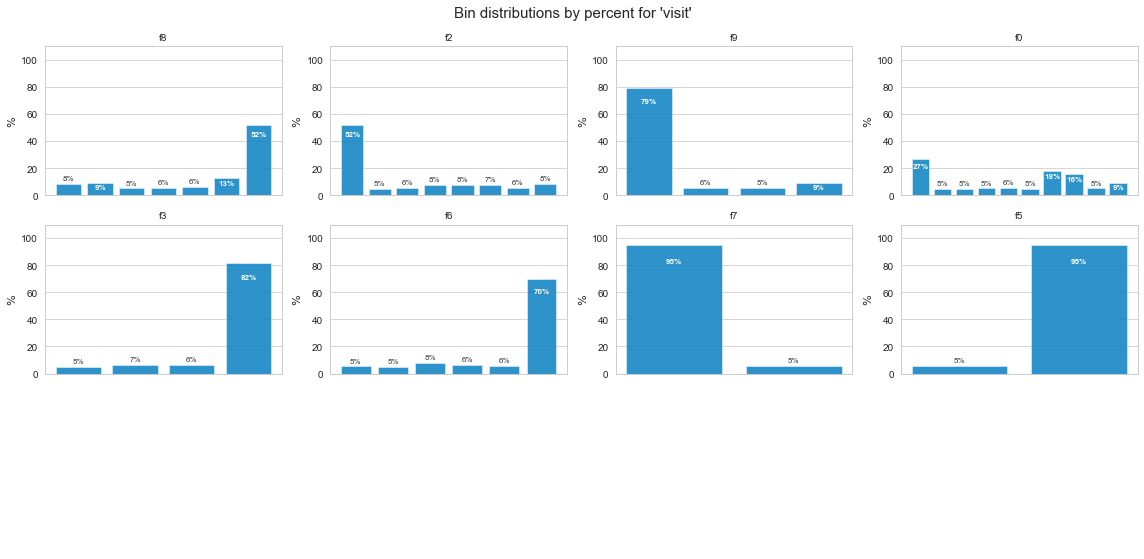

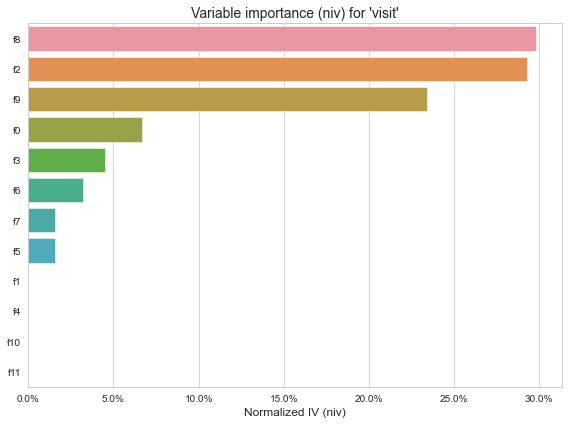

In [12]:
def plot_bin_histograms_percent(woe_df, features, n_cols=4, n_bins_show=12, title=None):
    """
    Визуализация распределения наблюдений по WoE-бинам для нескольких фич.
    Показывает долю (в процентах) объектов в каждом бине. 
    """
    n = len(features)
    n_rows = -(-n // n_cols)  # округление вверх для строк
    plt.figure(figsize=(4 * n_cols, 2.5 * n_rows))
    
    for idx, f in enumerate(features):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        data = woe_df[woe_df['feature'] == f]
        if len(data) == 0:
            ax.axis('off')
            continue

        s = data.sort_values("bin")
        counts = s["count"].values
        total = counts.sum()
        if total == 0:
            ax.axis('off')
            continue
        
        percents = 100 * counts / total
        bins = s["bin"].astype(str).values
        bins_show = bins[:n_bins_show]
        perc_show = percents[:n_bins_show]
        
        ax.bar(bins_show, perc_show, color='#1787c5', alpha=0.9)
        ax.set_title(f, fontsize=10)
        ax.set_xticks([])
        ax.set_ylabel("%")
        ax.set_ylim(0, 110)

        for i, val in enumerate(perc_show):
            if val > 9:
                ax.text(i, val * 0.9, f"{val:.0f}%", ha="center", va="top",
                        color="white", fontsize=8, fontweight="bold")
            elif val > 0:
                ax.text(i, val + 2, f"{val:.0f}%", ha="center", va="bottom", color="#333", fontsize=8)
    plt.tight_layout()
    if title:
        plt.suptitle(title, y=1.03, fontsize=15)
    plt.show()

def plot_var_importance(iv_agg_full, top_n=12, title=None):

    data = iv_agg_full.sort_values("niv", ascending=False).head(top_n)
    plt.figure(figsize=(8, max(2, 0.5 * top_n)))
    sns.barplot(y="feature", x="niv", data=data)
    plt.xlabel("Normalized IV (niv)", fontsize=12)
    plt.ylabel("")
    plt.title(title or "Variable importance", fontsize=14)
    
    # Форматируем ось X как проценты
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{100 * x:.1f}%"))
    
    plt.tight_layout()
    plt.show()

for target in targets:
    # Сортируем фичи по значению niv
    features_sorted = iv_tables[target].sort_values("niv", ascending=False)["feature"].tolist()

    plot_bin_histograms_percent(
        woe_tables[target],
        features_sorted,
        n_cols=4,
        title=f"Bin distributions by percent for '{target}'"
    )

    plot_var_importance(
        iv_tables[target],
        top_n=12,
        title=f"Variable importance (niv) for '{target}'"
    )

#### Комментарии к NWOE и NIV признаков:

- Чем более равномерно распределены объекты по бинам той или иной фичи, тем выше значение её нормализованной важности (NIV).
- Фичи f1, f4, f10 и f11 попали в единственный бин, поэтому их NIV равен нулю — то есть они не несут разделяющей информации для модели. В дальнейшем можно было бы исключить их из модели для ускорения расчётов и, возможно, даже не собирать эту информацию с пользователей.
- Наиболее информативными оказались переменные f2, f8 и f9 — у них максимальные значения NIV.
- Распределение важности признаков (NIV) практически совпадает для обеих целевых переменных: visit и conversion.

## Расчёт среднего эффекта воздействия (ATE), построение Qini-кривой

In [13]:
# Считаем долю пользователей, совершивших визит и конверсию, по группам treatment (эксперимент/контроль)
visit_perc_exp = pd.crosstab(df_group['treatment'], df_targets['visit'], normalize='index') * 100
conversion_perc_exp = pd.crosstab(df_group['treatment'], df_targets['conversion'], normalize='index') * 100

print('Visit (%)')
print(visit_perc_exp.round(1))
print('\nConversion (%)')
print(conversion_perc_exp.round(1))

Visit (%)
visit         0    1
treatment           
0          96.2  3.8
1          95.1  4.9

Conversion (%)
conversion     0    1
treatment            
0           99.8  0.2
1           99.7  0.3


In [14]:
# Аналогично, но по exposure (был ли реально контакт с акцией)
visit_perc_exp = pd.crosstab(df_group['exposure'], df_targets['visit'], normalize='index') * 100
conversion_perc_exp = pd.crosstab(df_group['exposure'], df_targets['conversion'], normalize='index') * 100

print("Visit_exp (%)")
print(visit_perc_exp.round(1))
print("\nConversion_exp (%)")
print(conversion_perc_exp.round(1))

Visit_exp (%)
visit        0     1
exposure            
0         96.5   3.5
1         58.5  41.5

Conversion_exp (%)
conversion     0    1
exposure             
0           99.9  0.1
1           94.6  5.4


Видим, что эффект воздействия сам по себе крайне мал, но при этом пользователи, которые реально повзаимодействовали с акцией показывают куда большее изменение целевых показателей.

In [15]:
# conversion
mean_conversion_treated = df.loc[df['treatment'] == 1, 'conversion'].mean()
mean_conversion_control = df.loc[df['treatment'] == 0, 'conversion'].mean()
ate_conversion = mean_conversion_treated - mean_conversion_control

# visit
mean_visit_treated = df.loc[df['treatment'] == 1, 'visit'].mean()
mean_visit_control = df.loc[df['treatment'] == 0, 'visit'].mean()
ate_visit = mean_visit_treated - mean_visit_control

print(f"Средний эффект воздействия (ATE) для 'conversion': {ate_conversion:.4f}")
print(f"Средний эффект воздействия (ATE) для 'visit': {ate_visit:.4f}")

Средний эффект воздействия (ATE) для 'conversion': 0.0012
Средний эффект воздействия (ATE) для 'visit': 0.0103


In [16]:
# conversion
mean_conversion_treated = df.loc[df['exposure'] == 1, 'conversion'].mean()
mean_conversion_control = df.loc[df['treatment'] == 0, 'conversion'].mean()
ate_conversion = mean_conversion_treated - mean_conversion_control

# visit
mean_visit_treated = df.loc[df['exposure'] == 1, 'visit'].mean()
mean_visit_control = df.loc[df['treatment'] == 0, 'visit'].mean()
ate_visit = mean_visit_treated - mean_visit_control

print(f"Средний эффект воздействия (ATE) с учётом 'exposure' для 'conversion': {ate_conversion:.4f}")
print(f"Средний эффект воздействия (ATE) с учётом 'exposure' для 'visit': {ate_visit:.4f}")

Средний эффект воздействия (ATE) с учётом 'exposure' для 'conversion': 0.0518
Средний эффект воздействия (ATE) с учётом 'exposure' для 'visit': 0.3763


Расчёты ATE подтверждают наше предположение, многократно отличаясь в нужную для нас сторону для пользователей, которые действительно контактировали с акцией.

In [17]:
df[df['treatment']==1]['exposure'].value_counts(normalize = True)

0    0.963963
1    0.036037
Name: exposure, dtype: float64

При этом заметим, что только $3.6\%$ пользователей, на которых было воздействие, действительно его восприняли, что говорит о том, что наша акция была крайне неэффективна с точки зрения привлечения внимания. Однако те, кто её увидел, показали хороший рост целевых показателей. Рекомендация: увеличивать видимость акции.

Построим qini-кривые для целевых показателей. В силу долгого счёта будем использовать только часть выборки.

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\ProgramData\Anaconda3\envs\Test\lib\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


<AxesSubplot:title={'center':'Qini curve'}, xlabel='Fraction of data', ylabel='Uplift gain'>

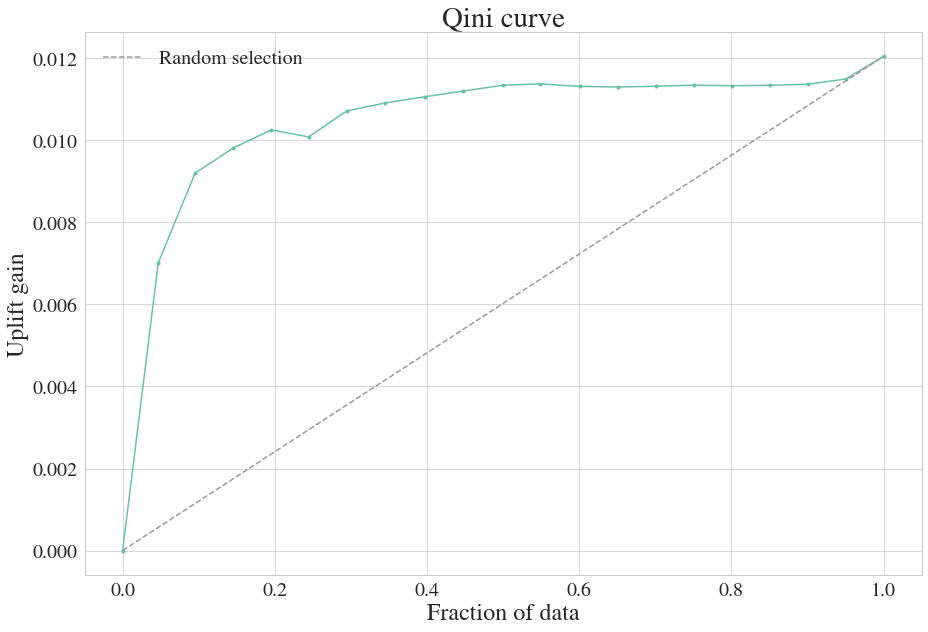

In [18]:
df_sub_v = df.sample(frac=0.05, random_state=42).reset_index(drop=True)

up_visit = TransformedOutcome(
    df_sub_v.drop(columns=['conversion', 'exposure']),  # исходные данные без лишних таргетов
    col_treatment='treatment',                          # какая колонка – признак "было воздействие/нет"
    col_outcome='visit',                                # какая колонка – целевое действие пользователя
    stratify=df_sub_v['treatment']                      # стратификация при разбиении train/test (сохраняем доли treatment/control)
)

# Подбираем гиперпараметры случайным поиском по их возможным значениям (RandomizedSearchCV)
up_visit.randomized_search(
    n_iter=10,        # сколько случайных комбинаций гиперпараметров проверим
    n_jobs=-1,        # параллельно во всех доступных потоках
    random_state=0,   # фиксируем seed для воспроизводимости
    verbose=2
)
# Обучаем модель на всех обучающих данных с лучшими найденными параметрами
up_visit.fit(**up_visit.rand_search_.best_params_)

# Визуализация Qini-кривой
up_visit.plot(plot_type="qini")

- Qini-кривая заметно выше линии случайного отбора — модель эффективно выделяет аудиторию, позитивно реагирующую на воздействие.
- Основной прирост достигается уже на первых 20–30% пользователей — именно на них стоит делать акцент при таргетировании.
- После 30% кривая выходит на плато: дальнейшее увеличение охвата даёт минимальный дополнительный эффект.

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\ProgramData\Anaconda3\envs\Test\lib\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


<AxesSubplot:title={'center':'Qini curve'}, xlabel='Fraction of data', ylabel='Uplift gain'>

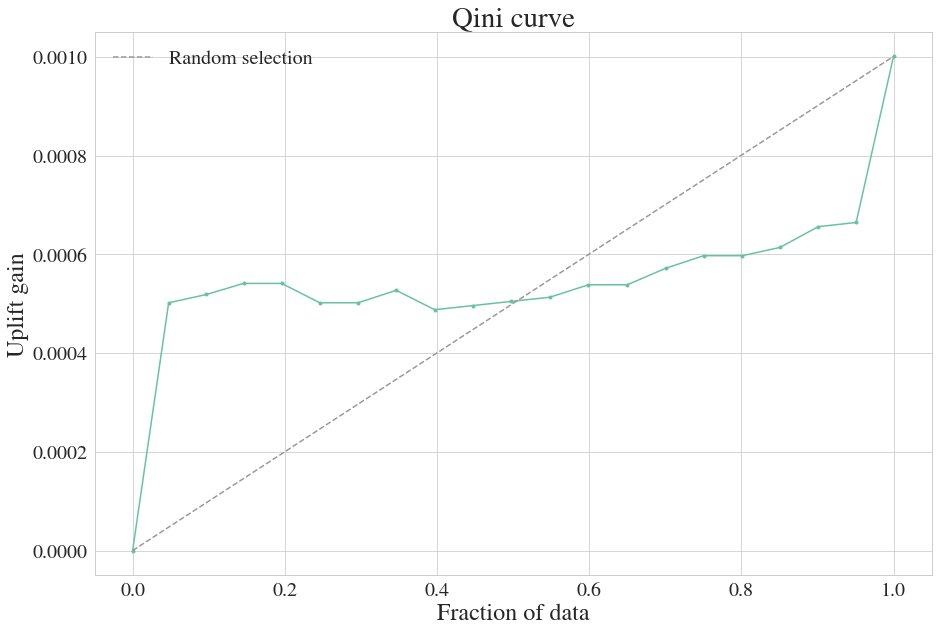

In [19]:
df_sub_c = df.sample(frac=0.05, random_state=42).reset_index(drop=True)

up_conversion = TransformedOutcome(
    df_sub_c.drop(columns=['visit', "exposure"]),       # исходные данные без лишних таргетов
    col_treatment='treatment',                          # какая колонка – признак "было воздействие/нет"
    col_outcome='conversion',                           # какая колонка – целевое действие пользователя
    stratify=df_sub_c['treatment']                      # стратификация при разбиении train/test (сохраняем доли treatment/control)
)

# Подбираем гиперпараметры случайным поиском по их возможным значениям (RandomizedSearchCV)
up_conversion.randomized_search(
    n_iter=10,        # сколько случайных комбинаций гиперпараметров проверим
    n_jobs=-1,        # параллельно во всех доступных потоках
    random_state=0,   # фиксируем seed для воспроизводимости
    verbose=2
)
# Обучаем модель на всех обучающих данных с лучшими найденными параметрами
up_conversion.fit(**up_conversion.rand_search_.best_params_)

# Визуализация Qini-кривой
up_conversion.plot(plot_type="qini")

- Кривая лежит практически на уровне случайного таргетирования (пунктирная линия), местами даже чуть ниже.
- В первые 20-30% объёма данных кривая относительно быстро растёт — значит, эти пользователи лучше откликаются на воздействие.
- На интервалы от 0.2 до 0.6 рост замедляется и есть даже плато/небольшие спады — модель различает "откликающихся" хуже, прирост здесь минимальный.
- После 0.6 снова небольшой рост — возможно, в "хвосте" тоже появились отдельные чувствительные к воздействию клиенты (либо из-за шума).

In [20]:
#Рассмотрим утопическую ситуацию, в которой мы смогли до всех пользователей, которым показывали акцию, донести её
df_filtered = df[(df['treatment'] == 0) | (df['exposure'] == 1)]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\ProgramData\Anaconda3\envs\Test\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\Test\lib\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


<AxesSubplot:title={'center':'Qini curve'}, xlabel='Fraction of data', ylabel='Uplift gain'>

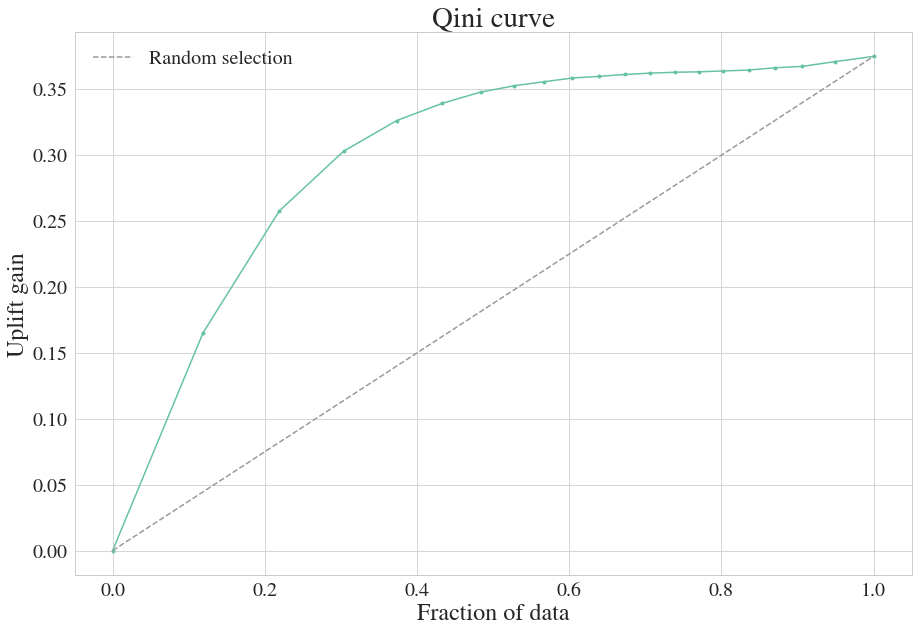

In [21]:
df_filtered_sample = df_filtered.sample(frac=0.1, random_state=42).reset_index(drop=True)

up_visit_filtered = TransformedOutcome(
    df_filtered_sample.drop(columns=['conversion', 'exposure']),  # исходные данные без лишних таргетов
    col_treatment='treatment',                              # колонка с признаком воздействия
    col_outcome='visit',                                    # колонка с целевым действием
    stratify=df_filtered_sample['treatment']                     # стратификация по treatment
)

# Подбор гиперпараметров случайным поиском
up_visit_filtered.randomized_search(
    n_iter=10,
    n_jobs=-1,
    random_state=0,
    verbose=2
)

# Обучение модели на лучших найденных параметрах
up_visit_filtered.fit(**up_visit_filtered.rand_search_.best_params_)

# Визуализация Qini-кривой
up_visit_filtered.plot(plot_type="qini")

- Значение uplift gain на максимуме ~0.36, что на порядки превышает максимум аналогичной кривой, посчитанной для treatment (0.012).
- Кривая лежит значительно выше случайного таргетирования по всей длине фрейма.
- Рост очень стабилен, без сильных провалов, и явно доминирует над диагональю.

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\ProgramData\Anaconda3\envs\Test\lib\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


<AxesSubplot:title={'center':'Qini curve'}, xlabel='Fraction of data', ylabel='Uplift gain'>

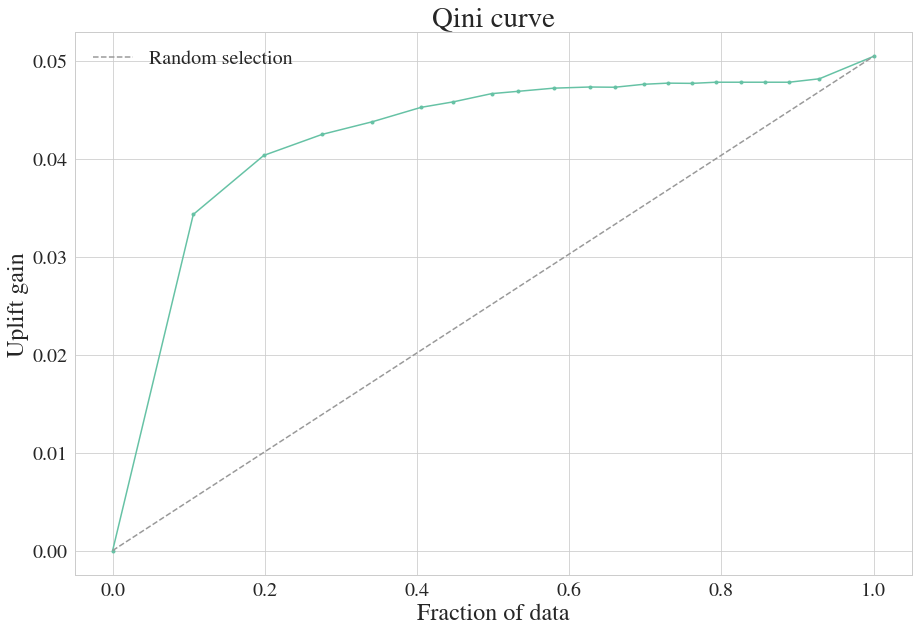

In [22]:
df_filtered_sample = df_filtered.sample(frac=0.1, random_state=42).reset_index(drop=True)

up_conversion_filtered = TransformedOutcome(
    df_filtered_sample.drop(columns=['visit', 'exposure']),       # исходные данные без лишних таргетов
    col_treatment='treatment',                             # колонка с признаком воздействия
    col_outcome='conversion',                              # колонка с целевым действием
    stratify=df_filtered_sample['treatment']                      # стратификация по treatment
)

# Подбор гиперпараметров случайным поиском
up_conversion_filtered.randomized_search(
    n_iter=10,
    n_jobs=-1,
    random_state=0,
    verbose=2
)

# Обучение модели на лучших найденных параметрах
up_conversion_filtered.fit(**up_conversion_filtered.rand_search_.best_params_)

# Визуализация Qini-кривой
up_conversion_filtered.plot(plot_type="qini")

- Значение uplift gain на максимуме ~0.05, что на порядки превышает максимум аналогичной кривой, посчитанной для treatment.
- Кривая лежит значительно выше случайного таргетирования по всей длине фрейма.
- Рост очень стабилен, без сильных провалов, и явно доминирует над диагональю.

Легко заметить, что в обоих случаях qini-кривая сильно улучшилась при переходе от пользователей, на которых пытались подействовать акцией к пользователям, которые с акцией успешно контактировали. Это означает, что сама акция действительно эффективна для аудитории, однако основной проблемой является низкая вовлечённость или информированность пользователей о её проведении. Следовательно, основное направление для улучшения — повышение видимости акции и проведение коммуникаций, чтобы как можно большее число пользователей получили возможность принять участие.